# Mask R-CNN - Train on Lungs dataset

Data that need to be downloaded and put to 'data' directory
- https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities
- https://www.kaggle.com/yoctoman/shcxr-lung-mask
- mask_rcnn_coco.h5 from https://github.com/matterport/Mask_RCNN/releases


kudos to https://github.com/matterport/Mask_RCNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import glob

# Root directory of the project
root_dir = os.path.abspath("")

# Import Mask RCNN
sys.path.append(root_dir)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
model_dir = os.path.join(root_dir, "logs")

# Local path to trained weights file
coco_model_path = os.path.join(root_dir, "data/mask_rcnn_coco.h5")
image_dir = f'{root_dir}/data/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png'
mask_dir = f'{root_dir}/data/shcxr-lung-mask/mask'

images_files = glob.glob(f'{image_dir}/*')
masks_files = glob.glob(f'{mask_dir}/*')

Using TensorFlow backend.


## Configurations

In [2]:
class LungsConfig(Config):
    """Configuration for training that derives from the base Config class and overrides values specific
    to the lungs shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "lungs"

    # Train on 1 GPU and 1images per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background +  lungs

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = LungsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [4]:
class LungsDataset(utils.Dataset):
    """Loads files and masks from paths passed as arguments.
    """

    def load_lungs(self, masks_paths, images_paths):
        """Load lungs images to dataset
        """
        # Add classes
        self.add_class("lungs", 1, "lungs")

        # Add images
        for m in masks_paths:
            image_name = m[len(mask_dir):].replace("_mask", "").replace("\\", "")
            image_path = f'{image_dir}\\{image_name}'
            if image_path in images_paths:
                self.add_image("lungs", 
                               image_id=image_name, 
                               path=image_path)

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "lungs":
            return info["lungs"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load mask image given image ID.
        """
        img_info = self.image_info[image_id]
        file_path = f'{mask_dir}/{img_info["id"].replace(".png", "_mask.png")}'
        im = matplotlib.image.imread(file_path)
        return im.reshape((*im.shape, 1)).astype(np.int32), np.array([1]).astype(np.int32)

In [5]:
test_train_split = 0.9
masks_count = len(masks_files)


# Training dataset
dataset_train = LungsDataset()
train_size = int(masks_count*test_train_split)
train_masks = masks_files[:train_size]
dataset_train.load_lungs(train_masks, images_files)
dataset_train.prepare()

# Validation dataset
dataset_val = LungsDataset()
test_size = int(masks_count*(1-test_train_split))
test_masks = masks_files[:test_size]
dataset_val.load_lungs(test_masks, images_files)
dataset_val.prepare()

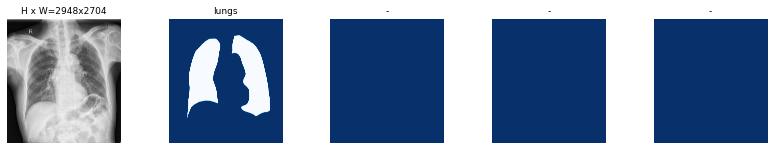

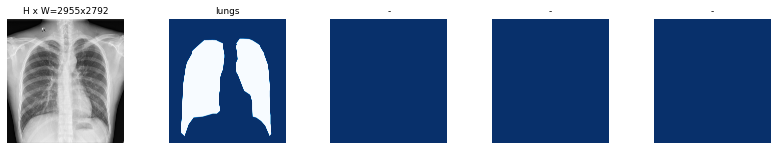

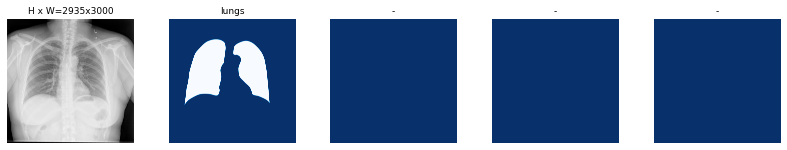

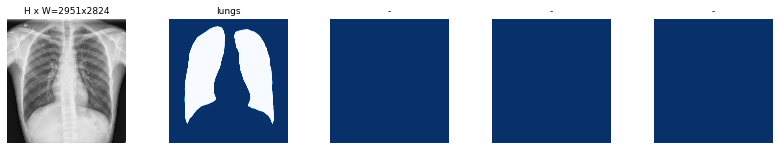

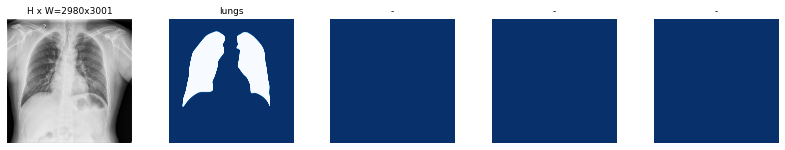

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=model_dir)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# start with coco model
model.load_weights(coco_model_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training

Train in two stages:
1. Only the heads. Freeze all backbone layers and train only randomly initialized layers, by passing `layers='heads'` argument

2. Fine-tune all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head layers.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Users\Bezio\Documents\.ubuntu\bench\ml\lungs detection Mask R-CNN\logs\lungs20200330T1323\mask_rcnn_lungs_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_

c:\Users\Admin\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\Admin\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\Admin\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/1
200/200 [==============================] - 1458s 7s/step - loss: 1.1056 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3094 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.3845 - val_loss: 0.6666 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.1212 - val_mrcnn_class_loss: 0.0284 - val_mrcnn_bbox_loss: 0.2180 - val_mrcnn_mask_loss: 0.2933



In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: D:\Users\Bezio\Documents\.ubuntu\bench\ml\lungs detection Mask R-CNN\logs\lungs20200330T1323\mask_rcnn_lungs_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNo

c:\Users\Admin\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\Admin\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\Admin\Miniconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2
200/200 [==============================] - 1608s 8s/step - loss: 0.5014 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1849 - val_loss: 0.5661 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.1249 - val_mrcnn_class_loss: 0.0221 - val_mrcnn_bbox_loss: 0.1774 - val_mrcnn_mask_loss: 0.2350


## Detection

In [11]:
class InferenceConfig(LungsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=model_dir)

# Get path to saved weights
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  D:\Users\Bezio\Documents\.ubuntu\bench\ml\lungs detection Mask R-CNN\logs\lungs20200330T1323\mask_rcnn_lungs_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 3000.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   20.00000  max:  107.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  int32


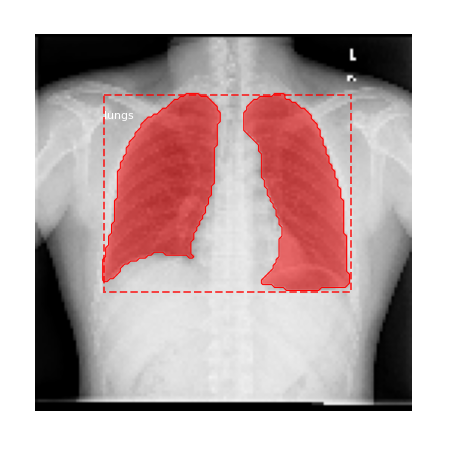

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


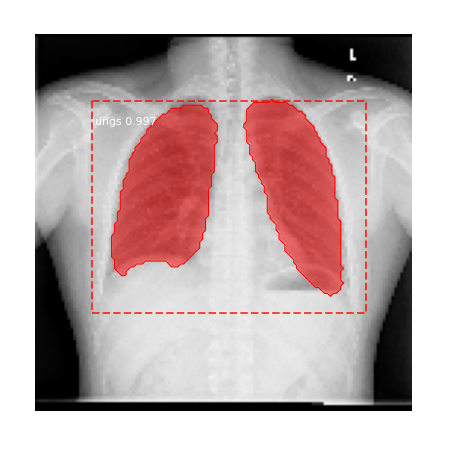

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 100 images.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
